In [1]:
import platform
print(platform.architecture())

('64bit', 'WindowsPE')


In [2]:
!python --version

Python 3.7.6


In [3]:
pwd

'C:\\Users\\sojeo\\OneDrive\\바탕 화면'

In [4]:
# 네이버에서 검색어 입력받아 검색 한 후 블로그 메뉴를 선택하고
# 오른쪽에 있는 검색옵션 버튼을 눌러서
# 정렬 방식과 기간을 입력하기

#Step 0. 필요한 모듈과 라이브러리를 로딩합니다.
import sys
import os
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from selenium import webdriver
import time
import tqdm
from tqdm.notebook import tqdm

In [5]:
query_txt = input('1.크롤링할 키워드는 무엇입니까?: ')
# query_txt2 = input('2.제외할 첫번째 키워드를 입력하세요: ')
# query_txt3 = input('3.제외할 두번째 키워드를 입력하세요: '|)

start_date = input('4.조회를 시작할 날짜를 입력하세요(예:20170101) :')
end_date = input('5.조회를 종료할 날짜를 입력하세요(예:20171231): ')

1.크롤링할 키워드는 무엇입니까?: 코로나
4.조회를 시작할 날짜를 입력하세요(예:20170101) :20200530
5.조회를 종료할 날짜를 입력하세요(예:20171231): 20200630


In [6]:
query_txt="확진"
start_date="20200601"
end_date="20200607"

In [8]:
#Step 1. 크롬 웹브라우저 실행
path = r"C:\Users\sojeo\OneDrive\바탕 화면\chromedriver_win32\chromedriver.exe"

driver = webdriver.Chrome(path)
# 사이트 주소는 네이버
driver.get('http://www.naver.com')
time.sleep(2)

#Step 2. 네이버 검색창에 "검색어" 검색
element = driver.find_element_by_id("query")
element.send_keys(query_txt)  # query_txt는 위에서 입력한 '코로나'
element.submit()

#Step 3. "블로그" 카테고리 선택
driver.find_element_by_link_text("블로그").click( )    # .click() 괄호 안을 눌러라는 뜻

#Step 4. 오른쪽의 검색 옵션 버튼 클릭
driver.find_element_by_id("_search_option_btn").click( )

#Step 5. 정렬 : "관련도순" 
# 개발자 도구에서 정렬 버튼의 id 가 보이지 않습니다.
# 이럴 경우 쉽게 사용할 수 있는 방법이 바로 xpath 를 이용하는 방법입니다.
# xpath는 개발자 도구에서 해당 메뉴 부분을 마우스 오른쪽 버튼을 누르고 
# copy -> copy xpath 를 선택하면 됩니다
driver.find_element_by_xpath("""//*[@id="snb"]/div/ul/li[1]/a""").click( )  # 정렬 버튼의 xpath 클릭
driver.find_element_by_xpath("""//*[@id="snb"]/div/ul/li[1]/div/ul/li[1]/a""").click( ) # 관련도순 xpath

#Step 6. 날짜 입력
driver.find_element_by_xpath("""//*[@id="snb"]/div/ul/li[2]/a""").click()
time.sleep(2)

# 이 부분이 아주 중요합니다.
# 날짜 부분에 날짜를 입력할 때 입력 속도가 너무 빠를 경우 날짜가 입력이 되다가 
# 오타가 나오는 경우가 많습니다.
# 그래서 날짜를 입력할 때 for 반복문을 사용해서 1 글자씩 입력하도록 코딩했습니다.

# 시작 날짜 입력하기
s_date = driver.find_element_by_xpath("""//*[@id="blog_input_period_begin"]""")     
driver.find_element_by_xpath("""//*[@id="blog_input_period_begin"]""").click()
s_date.clear( )  # 날짜 입력 부분에 기존에 입력되어 있던 날짜를 제거합니다. 
time.sleep(1)
# 아래 코드가 날짜를 for 반복문으로 1 글자씩 입력하는 부분입니다.
for c in start_date:
    s_date.send_keys(c)
    time.sleep(0.1)
    
# 종료 날짜 입력하기
e_date = driver.find_element_by_xpath("""//*[@id="blog_input_period_end"]""")
driver.find_element_by_xpath("""//*[@id="blog_input_period_end"]""").click()
e_date.clear()
time.sleep(1)

for c in end_date:
    e_date.send_keys(c)
    time.sleep(0.1)
    
# Step7. 날짜 입력 "적용하기" 버튼을 클릭 합니다.  
driver.find_element_by_class_name("tx").click()
time.sleep(3)

# # Step 8. 상세 검색버튼을 클릭 후 제외할 단어들을 설정합니다.
# ele2 = driver.find_element_by_id("inpop3")
# ele2.send_keys(query_txt2)
# ele2.send_keys(',')
# ele2.send_keys(query_txt3)
# driver.find_element_by_css_selector(".btn_ft.ty_green._search").click( )

## 글 url 크롤링 시작

In [9]:
url_list = []
title_list = []

# ★몇개의 페이지를 크롤링할지 선택
total_page = 10
for i in tqdm(range(0, total_page)):  # 페이지 번호
    i = i*10 + 1
    url = "https://search.naver.com/search.naver\
?date_from={0}&date_option=8&date_to={1}\
&dup_remove=1&nso=p%3Afrom{2}to{3}post_blogurl=\
&post_blogurl_without=&query={4}&sm=tab_pge&srchby=all&st=sim&where=post&start={5}".format(start_date,end_date,start_date,end_date,query_txt, i)
    driver.get(url)
    time.sleep(0.5)
    
    # URL 크롤링 시작
    titles = "a.sh_blog_title._sp_each_url._sp_each_title"
    article_raw = driver.find_elements_by_css_selector(titles)
#     article_raw

    # url 크롤링 시작    
    for article in article_raw:
        url = article.get_attribute('href')   
        url_list.append(url)
    
    # 제목 크롤링 시작    
    for article in article_raw:
        title = article.get_attribute('title')   
        title_list.append(title)
    
        print(title)
    
print('url갯수: ', len(url_list))
print('url갯수: ', len(title_list))

df = pd.DataFrame({'url':url_list, 'title':title_list})

# 저장하기
df.to_excel(r"C:\Users\sojeo\OneDrive\바탕 화면\blog_url.xlsx")

그리스 여행 온 카타르 발 여객기 12명 확진 나와!
대만은 지금 (20.6.1~6.5); 우한 폐렴 관련 대만동향/6.5일(00:30시) 누계, 확진 443명 (사망 7명, 격리해제 428명), 검사중 508명 ★
국내확진자 총11719명 6월6일 신규확진 51명,이태원 쿠팡 개척교회 방문판매업 탁구장 발 수도권 집단감염 확산 사회적 생활속거리두기 병행
당뇨병 환자 10명 중 1명 코로나19 확진 후 일주일 이내 사망
영덕동 어린이집 2명 추가 확진…용인시 누적 환자 100명 넘어서
9월 학기제 실시하자, 서울 영등포구 중학교 학생 확진
어제(6.2) 대구시 코로나19 확진환자는 1명입니다.
인천 개척교회발 감염 수도권 확산…목사 14명 등 26명 확진(종합)
고양이 피부병 비만세포종 발견과 림포마 확진
제약영업MR의 코로나19 확진을 비난하면 안되는 이유
+ (6/5) 괴질 '코로나19' / 전 세계 확진자 669만명 넘어…사망자 39만3천여명 / 국내 39명 확진, 총 11,668명
6월4일 현재(추가확진1+2)3명 코로나추가확진자 발생
수도권 중심 코로나19(신종 코로나바이러스 감염증) 집단감염 확진 환자 증가 추세
갑상선암 확진 위한 갑상선 총생검이 위험한 이유, 갑상선 주위 혈관 손상 가능성 [외과 전문의 민호균 원장]
6/2 인천 개척교회, 물류센터, 공무원 등 8명 추가확진
+ (6/1) 괴질 '코로나19' / 전 세계 확진자 626만명 넘어…사망자 37만4천여명 / 국내 35명 확진, 총 11,503명
[경기IN] 6월 1일 15시 기준 수원동부교회에서 8명 ‘확진’
수지서 2명 확진…용인 첫 교회 내 감염
서울 방판업체 리치웨이 무더기 확진/교회,방판업체 집단감염 "비상"
코로나19 집단감염 우려 높은 교정시설 확진 차단 총력
코로나19, 2020, 6.1일 ,추가확진 35, (국내감염 30) 총 11.503, 퇴원 17,(10.422), 사망 1 (271)
정정)폐렴확진 코로나음성 결핵 결과 기다리는 중
영천, 멕시코서 입국한 40대 여성 

## 글 크롤링

In [10]:
import sys
import pandas as pd
import numpy as np

In [11]:
# "url_list.csv" 불러오기
url_load = pd.read_excel(r"C:\Users\sojeo\OneDrive\바탕 화면\blog_url.xlsx")        # 기본 모델

num_list = len(url_load)

print(num_list)
url_load

100


,Unnamed: 0,url,title
0,0,https://blog.naver.com/dongi0508?Redirect=Log&...,그리스 여행 온 카타르 발 여객기 12명 확진 나와!
1,1,https://blog.naver.com/4julove?Redirect=Log&lo...,대만은 지금 (20.6.1~6.5); 우한 폐렴 관련 대만동향/6.5일(00:30시...
2,2,https://microibm.blog.me/221992069291,"국내확진자 총11719명 6월6일 신규확진 51명,이태원 쿠팡 개척교회 방문판매업 ..."
3,3,https://blog.naver.com/tommyr74?Redirect=Log&l...,당뇨병 환자 10명 중 1명 코로나19 확진 후 일주일 이내 사망
4,4,http://mediamh.co.kr/221991883174,영덕동 어린이집 2명 추가 확진…용인시 누적 환자 100명 넘어서
...,...,...,...
95,95,http://blog.daum.net/manna04/15610,인천 부흥회 연쇄감염에 신규확진 35명..지역발생 30명 중 수도권 29명(상보)
96,96,https://blog.naver.com/ph001144?Redirect=Log&l...,제약 영업사원 확진에 업계 우려
97,97,https://blog.naver.com/h1212818?Redirect=Log&l...,하양읍 거주 20대 여성 코로나19 ‘확진’
98,98,https://a1382a.tistory.com/274,"대웅 영업사원, 코로나 확진…'병원·약국' 등 수차례 방문"


In [12]:
dict = {}  # 전체 크롤링 데이터를 담을 그릇

# ★수집할 글 갯수
number = 10
for i in tqdm(range(0, number)): 
    # 글 띄우기
    url = url_load['url'][i]
    driver = webdriver.Chrome(r"C:\Users\sojeo\OneDrive\바탕 화면\chromedriver_win32\chromedriver.exe")
    driver.get(url)   # 글 띄우기
    
    # 크롤링
    
    try : 
        # iframe 접근
        driver.switch_to_frame('mainFrame')

        target_info = {}

        # 제목 크롤링 시작
        overlays = ".se-fs-.se-ff-"                                 
        tit = driver.find_element_by_css_selector(overlays)         # title
        title = tit.text
        title

        # 글쓴이 크롤링 시작
        overlays = ".nick"                                 
        nick = driver.find_element_by_css_selector(overlays)         # nick
        nickname = nick.text

        # 날짜 크롤링
        overlays = ".se_publishDate.pcol2"                                 
        date = driver.find_element_by_css_selector(overlays)         # date
        datetime = date.text

        # 내용 크롤링
        overlays = ".se-component.se-text.se-l-default"                                 
        contents = driver.find_elements_by_css_selector(overlays)         # date

        content_list = []
        for content in contents:
            content_list.append(content.text)

        content_str = ' '.join(content_list)

        # 글 하나는 target_info라는 딕셔너리에 담기게 되고,
        target_info['title'] = title
        target_info['nickname'] = nickname
        target_info['datetime'] = datetime
        target_info['content'] = content_str

        # 각각의 글은 dict라는 딕셔너리에 담기게 됩니다.
        dict[i] = target_info
        time.sleep(1)
        
        print(i, title)

        # 글 하나 크롤링 후 크롬 창 닫기
        driver.close()       
    
    # 에러나면 현재 크롬창 닫고 다음 글(i+1)로 이동
    except:
        driver.close()
        time.sleep(1)
        continue
    
    # 중간,중간에 파일로 저장하기
    if i == 30 or 50 or 80:
        # 판다스로 만들기
        import pandas as pd
        result_df = pd.DataFrame.from_dict(dict, 'index')

        # 저장하기
        result_df.to_excel(r"C:\Users\sojeo\OneDrive\바탕 화면\blog_contents_코로나확진.xlsx")
        time.sleep(3)

print('수집한 글 갯수: ', len(dict))
print(dict)

# 판다스로 만들기
import pandas as pd
result_df = pd.DataFrame.from_dict(dict, 'index')

# 저장하기
result_df.to_excel(r"C:\Users\sojeo\OneDrive\바탕 화면\blog_contents_코로나확진.xlsx")

C:\Users\sojeo\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: use driver.switch_to.frame instead
  from ipykernel import kernelapp as app


0 그리스 여행 온 카타르 발 여객기 12명 확진 나와!
1 
3 -코로나19 확진 후 당뇨병 환자 5명 중 1명은 인공호흡기 필요 
9 제약영업MR의 코로나19 확진을 비난하면 안되는 이유

수집한 글 갯수:  4
{0: {'title': '그리스 여행 온 카타르 발 여객기 12명 확진 나와!', 'nickname': '김덮밥', 'datetime': '2020. 6. 4. 8:00', 'content': '그리스 여행 온 카타르 발 여객기 12명 확진 나와!\n유럽에서 가장 먼저 관광 관련 빗장을 푼게 여기랑 또 오스트리아. 이외에 몇 나라 있지만 역시는 역시였나. 너무 섣부르게 봉쇄조치를 해제한게 아닌가 했는데. 이런 뉴스도 나오는구나. 근데 또 이 국가들 상황도 이해가 가긴 하다. 국내총생산 등 여러 수치에서 관광업의 비중이 어마무시하게 크고 한 해의 업종 승패에 따라 잘 먹고사느냐 아니냐가 판가름 나니까. 그치만 아무리 입국 허용조치가 되었다고 해도 그리스 여행은 시기상조인 것 같다는게 내 생각이다. 도하에서 출발했던 비행기 안에서 코로나 바이러스 확진자 12명 나왔다고 하는데. 자세한 내용 아래 통해 알아본다. 우선 메인 뉴스 알아보기 전에 그리스는 오는 6월15일부터 우리나라를 포함한 일본 중국 호주 등 주요국 29개 나라에 대해 관광 목적으로의 입국을 허가한다고 밝힌바 있음. 고로 항공편 노선만 있으면 문제없이 놀고 그러고 다시 본국으로 귀국을 할 수 있는 것이다. 희망찬 소식이었는데... 그리스 여행 목적이든 뭐든 카타르에서 들어온 승객들 중에서 바이러스 감염 환자가 대거 발생하여 해당 항공편 노선이 잠정적으로 중단되었음. 일단 비행기에서 걸린거라고 보기보다는 이전의 카타르 도하 공항에서 탑승수속 전부터 이미 걸려있었을 확률이 높다고 한다. 로이터 통신에 의하면 현지시각 6월2일자로 전날 도하를 출발하여 아테네 도착한 비행기의 총 승객 91명 중에서 무려 12명이나 코로나 검사에서 확진받았다고 함. 고로 당국은 이 사실을 곧바로 인지하고 해당 

## 내용 텍스트 분석

In [15]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [16]:
# !pip install graphviz
# !pip install konlpy

import scipy as sp
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 그래프
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz             
from sklearn.tree import export_graphviz

# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
                                        # 맥 os:  
rc('font', family=font_name)

# 워닝 없애주는 것
import warnings  
warnings.filterwarnings('ignore')

In [17]:
from konlpy.tag import Kkma       ; kkma = Kkma()
from konlpy.tag import Hannanum   ; hannanum = Hannanum()
from konlpy.tag import Okt        ; t = Okt()
from konlpy.tag import *
import pickle

In [18]:
df_r = pd.read_excel(r"C:\Users\sojeo\OneDrive\바탕 화면\blog_contents_코로나확진.xlsx")
df_r

,Unnamed: 0,title,nickname,datetime,content
0,0,그리스 여행 온 카타르 발 여객기 12명 확진 나와!,김덮밥,2020. 6. 4. 8:00,그리스 여행 온 카타르 발 여객기 12명 확진 나와!\n유럽에서 가장 먼저 관광 관...
1,1,NaN,자메스,2020. 6. 5. 17:25,대만은 지금\n대만의 주요 경제 동향으로 만나드립니다. * 대만 일일 경제뉴스(20...
2,3,-코로나19 확진 후 당뇨병 환자 5명 중 1명은 인공호흡기 필요,뷰티헬스신문,2020. 6. 2. 0:12,-코로나19 확진 후 당뇨병 환자 5명 중 1명은 인공호흡기 필요 \n-65세에서 ...
3,9,제약영업MR의 코로나19 확진을 비난하면 안되는 이유,세일즈멘토 김종구,2020. 6. 2. 10:51,최근 제약회사의 영업담당자(MR : Medical Representative)의 C...


In [19]:
df_r['content']

0    그리스 여행 온 카타르 발 여객기 12명 확진 나와!\n유럽에서 가장 먼저 관광 관...
1    대만은 지금\n대만의 주요 경제 동향으로 만나드립니다. * 대만 일일 경제뉴스(20...
2    -코로나19 확진 후 당뇨병 환자 5명 중 1명은 인공호흡기 필요 \n-65세에서 ...
3    최근 제약회사의 영업담당자(MR : Medical Representative)의 C...
Name: content, dtype: object

In [20]:
content_list = df_r.content.values.tolist()

print(len(content_list))
content_list

4


['그리스 여행 온 카타르 발 여객기 12명 확진 나와!\n유럽에서 가장 먼저 관광 관련 빗장을 푼게 여기랑 또 오스트리아. 이외에 몇 나라 있지만 역시는 역시였나. 너무 섣부르게 봉쇄조치를 해제한게 아닌가 했는데. 이런 뉴스도 나오는구나. 근데 또 이 국가들 상황도 이해가 가긴 하다. 국내총생산 등 여러 수치에서 관광업의 비중이 어마무시하게 크고 한 해의 업종 승패에 따라 잘 먹고사느냐 아니냐가 판가름 나니까. 그치만 아무리 입국 허용조치가 되었다고 해도 그리스 여행은 시기상조인 것 같다는게 내 생각이다. 도하에서 출발했던 비행기 안에서 코로나 바이러스 확진자 12명 나왔다고 하는데. 자세한 내용 아래 통해 알아본다. 우선 메인 뉴스 알아보기 전에 그리스는 오는 6월15일부터 우리나라를 포함한 일본 중국 호주 등 주요국 29개 나라에 대해 관광 목적으로의 입국을 허가한다고 밝힌바 있음. 고로 항공편 노선만 있으면 문제없이 놀고 그러고 다시 본국으로 귀국을 할 수 있는 것이다. 희망찬 소식이었는데... 그리스 여행 목적이든 뭐든 카타르에서 들어온 승객들 중에서 바이러스 감염 환자가 대거 발생하여 해당 항공편 노선이 잠정적으로 중단되었음. 일단 비행기에서 걸린거라고 보기보다는 이전의 카타르 도하 공항에서 탑승수속 전부터 이미 걸려있었을 확률이 높다고 한다. 로이터 통신에 의하면 현지시각 6월2일자로 전날 도하를 출발하여 아테네 도착한 비행기의 총 승객 91명 중에서 무려 12명이나 코로나 검사에서 확진받았다고 함. 고로 당국은 이 사실을 곧바로 인지하고 해당 노선을 일단 중단시켰다. 잠정적으로 15일까지는 스톱이라고 하는데 재개가 될지는 불확실하다. 우선 중동쪽에서 거리상 그렇게 멀지가 않음. 게다가 90명 타고 있었다고 하니 왠만하면 소형기종을 띄웠을 것 같은 느낌인데 같이 탄 사람이 걱정 해당 열두명의 환자들은 이미 그전에 걸려있었다고 보면 된다. 그런 사람들이 이제 여객기 타고 입국하려고 하다가 검사에서 양성이 나온것이고. 그런게 걱정이다. 공항 들어와서 

In [21]:
import nltk
from konlpy.tag import Okt; t = Okt()

In [22]:
# 리스트 중 str 타입이 아닌 요소들이 존재함을 확인
for i in content_list:
    if type(i) == float:
        i = str(i)
        print(i)

In [23]:
# str 타입이 아닌 요소들이 있으면 전부 str 타입으로 바꿔라!
for i in range(len(content_list)):
    if type(content_list[i]) != str:
        content_list[i] = str(content_list[i])

In [24]:
content_text = ''

for each_line in content_list[:2000]:
    content_text = content_text + each_line + '\n'

In [25]:
content_text

'그리스 여행 온 카타르 발 여객기 12명 확진 나와!\n유럽에서 가장 먼저 관광 관련 빗장을 푼게 여기랑 또 오스트리아. 이외에 몇 나라 있지만 역시는 역시였나. 너무 섣부르게 봉쇄조치를 해제한게 아닌가 했는데. 이런 뉴스도 나오는구나. 근데 또 이 국가들 상황도 이해가 가긴 하다. 국내총생산 등 여러 수치에서 관광업의 비중이 어마무시하게 크고 한 해의 업종 승패에 따라 잘 먹고사느냐 아니냐가 판가름 나니까. 그치만 아무리 입국 허용조치가 되었다고 해도 그리스 여행은 시기상조인 것 같다는게 내 생각이다. 도하에서 출발했던 비행기 안에서 코로나 바이러스 확진자 12명 나왔다고 하는데. 자세한 내용 아래 통해 알아본다. 우선 메인 뉴스 알아보기 전에 그리스는 오는 6월15일부터 우리나라를 포함한 일본 중국 호주 등 주요국 29개 나라에 대해 관광 목적으로의 입국을 허가한다고 밝힌바 있음. 고로 항공편 노선만 있으면 문제없이 놀고 그러고 다시 본국으로 귀국을 할 수 있는 것이다. 희망찬 소식이었는데... 그리스 여행 목적이든 뭐든 카타르에서 들어온 승객들 중에서 바이러스 감염 환자가 대거 발생하여 해당 항공편 노선이 잠정적으로 중단되었음. 일단 비행기에서 걸린거라고 보기보다는 이전의 카타르 도하 공항에서 탑승수속 전부터 이미 걸려있었을 확률이 높다고 한다. 로이터 통신에 의하면 현지시각 6월2일자로 전날 도하를 출발하여 아테네 도착한 비행기의 총 승객 91명 중에서 무려 12명이나 코로나 검사에서 확진받았다고 함. 고로 당국은 이 사실을 곧바로 인지하고 해당 노선을 일단 중단시켰다. 잠정적으로 15일까지는 스톱이라고 하는데 재개가 될지는 불확실하다. 우선 중동쪽에서 거리상 그렇게 멀지가 않음. 게다가 90명 타고 있었다고 하니 왠만하면 소형기종을 띄웠을 것 같은 느낌인데 같이 탄 사람이 걱정 해당 열두명의 환자들은 이미 그전에 걸려있었다고 보면 된다. 그런 사람들이 이제 여객기 타고 입국하려고 하다가 검사에서 양성이 나온것이고. 그런게 걱정이다. 공항 들어와서 이

### 형태소분석을 마친 단어로 만든 token_ko

In [26]:
tokens_ko = t.morphs(content_text)
tokens_ko

['그리스',
 '여행',
 '온',
 '카타르',
 '발',
 '여객기',
 '12',
 '명',
 '확진',
 '나와',
 '!',
 '\n',
 '유럽',
 '에서',
 '가장',
 '먼저',
 '관광',
 '관련',
 '빗장',
 '을',
 '푼',
 '게',
 '여기',
 '랑',
 '또',
 '오스트리아',
 '.',
 '이외',
 '에',
 '몇',
 '나라',
 '있지만',
 '역시',
 '는',
 '역시였나',
 '.',
 '너무',
 '섣부르게',
 '봉쇄',
 '조치',
 '를',
 '해제',
 '한',
 '게',
 '아닌가',
 '했는데',
 '.',
 '이런',
 '뉴스',
 '도',
 '나오는구나',
 '.',
 '근데',
 '또',
 '이',
 '국가',
 '들',
 '상황',
 '도',
 '이해',
 '가',
 '가긴',
 '하다',
 '.',
 '국내총생산',
 '등',
 '여러',
 '수치',
 '에서',
 '관광업',
 '의',
 '비중',
 '이',
 '어마',
 '무시',
 '하',
 '게',
 '크고',
 '한',
 '해',
 '의',
 '업종',
 '승패',
 '에',
 '따라',
 '잘',
 '먹고사느냐',
 '아니냐가',
 '판가름',
 '나',
 '니까',
 '.',
 '그치만',
 '아무리',
 '입국',
 '허용',
 '조',
 '치가',
 '되었다고',
 '해도',
 '그리스',
 '여행',
 '은',
 '시기상조',
 '인',
 '것',
 '같다는게',
 '내',
 '생각',
 '이다',
 '.',
 '도하',
 '에서',
 '출발',
 '했던',
 '비행기',
 '안',
 '에서',
 '코로나',
 '바이러스',
 '확',
 '진자',
 '12',
 '명',
 '나왔다고',
 '하는데',
 '.',
 '자세한',
 '내용',
 '아래',
 '통해',
 '알아본다',
 '.',
 '우선',
 '메인',
 '뉴스',
 '알아보기',
 '전',
 '에',
 '그리스',
 '는',
 '오는',
 '6월',
 '1

In [27]:
ko = nltk.Text(tokens_ko)   
print(len(ko.tokens))          # 토큰 전체 갯수
print(len(set(ko.tokens)))     # 토큰 unique 갯수

3581
1346


In [28]:
ko = nltk.Text(tokens_ko)
ko.vocab().most_common(100)    # 가장 많이 나온 단어 100개

[('\n', 100),
 ('.', 99),
 (',', 77),
 ('(', 68),
 ('이', 62),
 (')', 58),
 ('명', 47),
 ('의', 47),
 ('-', 46),
 ('을', 43),
 ('에', 43),
 ('은', 43),
 ('것', 27),
 ('를', 26),
 ('가', 26),
 ('19', 25),
 ('는', 24),
 ('중', 24),
 ('에서', 22),
 ('환자', 22),
 ('대만', 21),
 ('으로', 20),
 ('코로나', 19),
 ('적', 19),
 ('들', 18),
 ('ㅇ', 18),
 ('수', 17),
 ('사망', 17),
 (':', 17),
 ('*', 16),
 ('영업', 16),
 ('도', 15),
 ('로', 15),
 ('있다', 15),
 ('감염', 14),
 ('검사', 14),
 ('당뇨병', 13),
 ('세', 13),
 ('확진', 12),
 ('전', 12),
 ('개', 12),
 ('기업', 12),
 ('달러', 12),
 ('한', 11),
 ('인', 11),
 ('할', 11),
 ('“', 11),
 ('코', 11),
 ('등', 10),
 ('과', 10),
 ('),', 10),
 ('”', 10),
 ('1', 10),
 ('제', 10),
 ('원', 10),
 ('하는', 10),
 ('있는', 9),
 ('경제', 9),
 ('5', 9),
 ('담당자', 9),
 ('발생', 8),
 ('하고', 8),
 ('위험', 8),
 ('후', 8),
 ('증가', 8),
 ('배', 8),
 ('그리스', 7),
 ('여행', 7),
 ('해', 7),
 ('내', 7),
 ('확', 7),
 ('격리', 7),
 ('이상', 7),
 ('계', 7),
 ('이내', 7),
 ('R', 7),
 ('&', 7),
 ('D', 7),
 ('지원', 7),
 ('연', 7),
 ('비난', 7),
 ('제약', 7),
 ('뉴

In [29]:
# 불용어 : 인터넷 검색 시 검색 용어로 사용하지 않는 단어. 관사, 전치사, 조사, 접속사 등 검색 색인 단어로 의미가 없는 단어
stop_words = [')','?','1','"(', '_', ')/','\n','.',',', '<','!','(','(', '??','..', '4', '|', '>', '?(', '"…', '#', '&', '・', "']",'.',' ','/',"'",'’','”','“','·', '[','!','\n','·','‘','"','\n ',']',':','…',')','(','-', 'nan','가','요','답변','...','을','수','에','질문','제','를','이','도',
                      '좋','1','는','로','으로','2','것','은','다',',','니다','대','들',
                      '2017','들','데','..','의','때','겠','고','게','네요','한','일','할',
                      '10','?','하는','06','주','려고','인데','거','좀','는데','~','ㅎㅎ',
                      '하나','이상','20','뭐','까','있는','잘','습니다','다면','했','주려',
                      '지','있','못','후','중','줄','6','과','어떤','기본','!!',
                      '단어','라고','중요한','합','가요','....','보이','네','무지','했습니다',
              '이다','대해','에게','입니다','있다','사람','대한','3','합니다','및','장','에서','하고','검','한다','만',
             '적', '성', '삼', '등', '전', '인', '그', '했다', '와', '위', '해', '권', '된', '서', '말', '분']

tokens_ko = [each_word for each_word in tokens_ko
             if each_word not in stop_words]

ko = nltk.Text(tokens_ko)
ko.vocab().most_common(50)

[('명', 47),
 ('19', 25),
 ('환자', 22),
 ('대만', 21),
 ('코로나', 19),
 ('ㅇ', 18),
 ('사망', 17),
 ('*', 16),
 ('영업', 16),
 ('감염', 14),
 ('검사', 14),
 ('당뇨병', 13),
 ('세', 13),
 ('확진', 12),
 ('개', 12),
 ('기업', 12),
 ('달러', 12),
 ('코', 11),
 ('),', 10),
 ('원', 10),
 ('경제', 9),
 ('5', 9),
 ('담당자', 9),
 ('발생', 8),
 ('위험', 8),
 ('증가', 8),
 ('배', 8),
 ('그리스', 7),
 ('여행', 7),
 ('내', 7),
 ('확', 7),
 ('격리', 7),
 ('계', 7),
 ('이내', 7),
 ('R', 7),
 ('D', 7),
 ('지원', 7),
 ('연', 7),
 ('비난', 7),
 ('제약', 7),
 ('뉴스', 6),
 ('하', 6),
 ('진자', 6),
 ('기', 6),
 ('시간', 6),
 ('보다', 6),
 ('화', 6),
 ('수요', 6),
 ('최근', 6),
 ('투자', 6)]

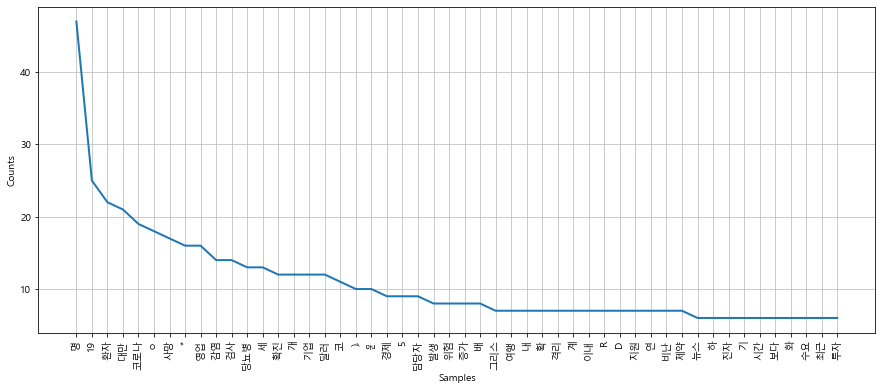

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz             
from sklearn.tree import export_graphviz
plt.figure(figsize=(15,6))
ko.plot(50) 
plt.show()

# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

In [31]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [32]:
data = ko.vocab().most_common(300)

print(len(data))
data

300


[('명', 47),
 ('19', 25),
 ('환자', 22),
 ('대만', 21),
 ('코로나', 19),
 ('ㅇ', 18),
 ('사망', 17),
 ('*', 16),
 ('영업', 16),
 ('감염', 14),
 ('검사', 14),
 ('당뇨병', 13),
 ('세', 13),
 ('확진', 12),
 ('개', 12),
 ('기업', 12),
 ('달러', 12),
 ('코', 11),
 ('),', 10),
 ('원', 10),
 ('경제', 9),
 ('5', 9),
 ('담당자', 9),
 ('발생', 8),
 ('위험', 8),
 ('증가', 8),
 ('배', 8),
 ('그리스', 7),
 ('여행', 7),
 ('내', 7),
 ('확', 7),
 ('격리', 7),
 ('계', 7),
 ('이내', 7),
 ('R', 7),
 ('D', 7),
 ('지원', 7),
 ('연', 7),
 ('비난', 7),
 ('제약', 7),
 ('뉴스', 6),
 ('하', 6),
 ('진자', 6),
 ('기', 6),
 ('시간', 6),
 ('보다', 6),
 ('화', 6),
 ('수요', 6),
 ('최근', 6),
 ('투자', 6),
 ('구', 6),
 ('약', 6),
 ('12', 5),
 ('관광', 5),
 ('해제', 5),
 ('이미', 5),
 ('총', 5),
 ('함', 5),
 ('이라고', 5),
 ('더', 5),
 ('일일', 5),
 ('누', 5),
 ('7', 5),
 ('단계', 5),
 ('결과', 5),
 ('G', 5),
 ('하기', 5),
 ('사회', 5),
 ('가능성', 5),
 ('팀', 5),
 ('카타르', 4),
 ('조치', 4),
 ('나', 4),
 ('생각', 4),
 ('비행기', 4),
 ('바이러스', 4),
 ('부터', 4),
 ('소식', 4),
 ('해당', 4),
 ('이나', 4),
 ('까지는', 4),
 ('치료', 4),
 ('지금', 4),
 

In [33]:
# list tuple을 딕셔너리로 만들어주는 함수
def todict(list_tuple):    
    todict = {}
    for i in range(0,len(list_tuple)):
        todict[data[i][0]] = data[i][1]
    return todict

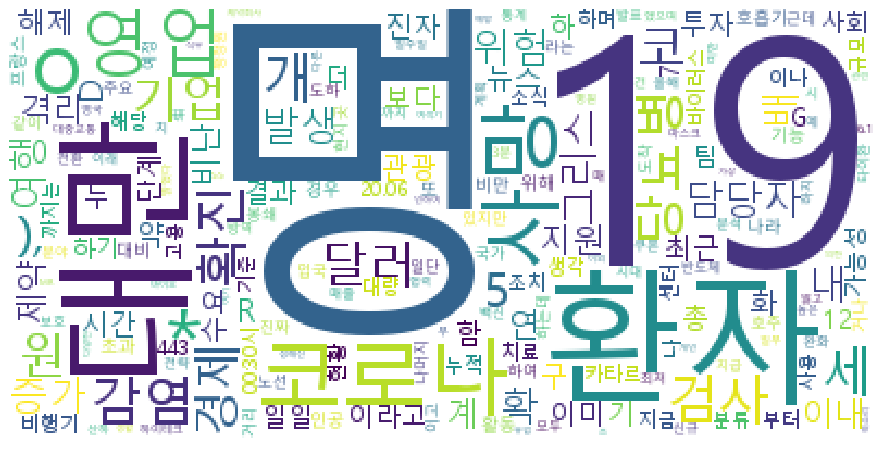

In [34]:
# 워드클라우드를 그려보자
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(todict(data))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()